In [ ]:
!pip install evaluate
# 1. Xử lý dữ liệu và biểu diễn bảng
import pandas as pd
import numpy as np

# 2. Xử lý và chia tập dữ liệu
import re
from sklearn.model_selection import train_test_split

# 3. Thư viện Hugging Face
from datasets import load_dataset
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments
)

# 4. Thư viện đánh giá mô hình
import evaluate

# 5. Xử lý tensor và dữ liệu cho mô hình
from torch.utils.data import Dataset
import torch

Load dữ liệu

In [ ]:
# 1. Tải dataset từ Hugging Face
dataset = load_dataset("viethq1906/VLSP2016")
print(dataset)

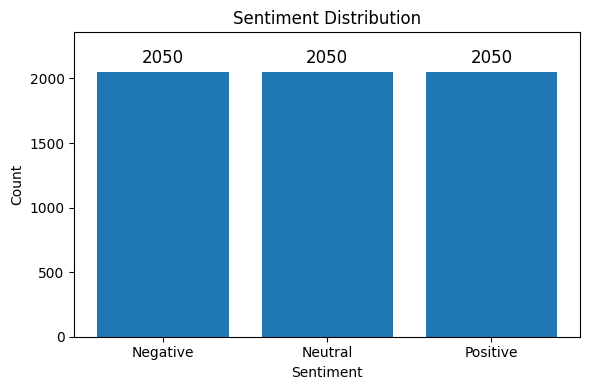

In [ ]:
import matplotlib.pyplot as plt
from collections import Counter

# Ép về list để cộng được
all_sentiments = (
    list(dataset["train"]["sentiment"]) +
    list(dataset["validation"]["sentiment"]) +
    list(dataset["test"]["sentiment"])
)

count = Counter(all_sentiments)

labels = ['Negative', 'Neutral', 'Positive']
values = [count[-1], count[0], count[1]]

plt.figure(figsize=(6, 4))
bars = plt.bar(labels, values)


max_val = max(values)
plt.ylim(0, max_val * 1.15)


for bar in bars:
    yval = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        yval + max_val * 0.02,    # đẩy text lên cao hơn
        str(yval),
        ha='center',
        va='bottom',
        fontsize=12
    )

plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.title("Sentiment Distribution")
plt.tight_layout()
plt.show()

Tiền xử lý dữ liệu

In [ ]:
# 1. Load PhoBERT tokenizer
tokenizer = AutoTokenizer.from_pretrained("vinai/phobert-base")

# 2. Tokenize từng câu trong dataset
def tokenize_function(examples):
    return tokenizer(
        examples["sentence"],
        padding="max_length",
        truncation=True,
        max_length=128
    )

# 3. Áp dụng tokenization cho toàn bộ dataset
tokenized_datasets = dataset.map(tokenize_function, batched=True)

# 4. Đổi tên cột "sentiment" thành "labels" để tương thích với Trainer
tokenized_datasets = tokenized_datasets.rename_column("sentiment", "labels")

# 5. Chuẩn hóa giá trị nhãn: [-1, 0, 1] → [0, 1, 2]
def remap_labels(example):
    if example["labels"] == -1:
        example["labels"] = 0
    elif example["labels"] == 0:
        example["labels"] = 1
    elif example["labels"] == 1:
        example["labels"] = 2
    return example

tokenized_datasets = tokenized_datasets.map(remap_labels)

# 6. Giữ lại các cột cần thiết
tokenized_datasets.set_format("torch", columns=["input_ids", "attention_mask", "labels"])

# 7. Tách tập train, validation và test
train_dataset = tokenized_datasets["train"]
valid_dataset = tokenized_datasets["validation"]
test_dataset  = tokenized_datasets["test"]

# Kiểm tra thông tin tập train
print(train_dataset)

Huấn luyện mô hình

In [ ]:
# 1. Load mô hình PhoBERT
model = AutoModelForSequenceClassification.from_pretrained("vinai/phobert-base", num_labels=3)
# 2. Cấu hình tham số huấn luyện
training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=4,
    weight_decay=0.01,
    logging_dir="./logs",
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    report_to="none"
)
# 3. Định nghĩa các metric đánh giá
accuracy = evaluate.load("accuracy")
f1 = evaluate.load("f1")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    return {
        "accuracy": accuracy.compute(predictions=preds, references=labels)["accuracy"],
        "f1": f1.compute(predictions=preds, references=labels, average="weighted")["f1"]
    }

# 4. Khởi tạo Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=valid_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

# 5. Bắt đầu huấn luyện mô hình
trainer.train()

# 6. Lưu MODEL + TOKENIZER đầy đủ
trainer.save_model("./phobert-sentiment")
tokenizer.save_pretrained("./phobert-sentiment")

Thử nghiệm

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Load lại cả tokenizer và model đã fine-tune
tokenizer = AutoTokenizer.from_pretrained("/content/drive/MyDrive/phobert-sentiment")
model = AutoModelForSequenceClassification.from_pretrained(
    "/content/drive/MyDrive/phobert-sentiment"
)
# Danh sách các câu cần test
texts = [
    "tôi không thích",
    "sản phẩm rất tốt",
    "chất lượng quá tệ",
    "dịch vụ chỉ ở mức bình thường",
    "tôi cực kỳ hài lòng",
]

label_map = {0: "negative", 1: "neutral", 2: "positive"}

# Dự đoán cho nhiều câu
for text in texts:
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True)
    outputs = model(**inputs)
    pred = outputs.logits.argmax(-1).item()
    print(f"Văn bản: {text}")
    print(f"Cảm xúc dự đoán: {label_map[pred]}")
    print("---------------")

Load dataset gốc và Gộp dataset gốc + synthetic

In [ ]:
from datasets import load_dataset

base = load_dataset("viethq1906/VLSP2016")
train_base = base["train"]
val_base = base["validation"]
test_base = base["test"]

print(len(train_base), len(val_base), len(test_base))

Load Synthetic Data

In [ ]:
from datasets import load_dataset

synthetic_ds = load_dataset(
    "json",
    data_files="/content/drive/MyDrive/NLP/synthetic_sentiment.json"
)["train"]

print("Số mẫu synthetic:", len(synthetic_ds))
synthetic_ds[0]

Lọc sạch synthetic dataset

In [ ]:
from datasets import Dataset

def clean_synthetic(ds):
    cleaned = []

    for ex in ds:
        s = ex.get("sentence", "")
        lab = ex.get("sentiment", None)

        # Bỏ câu rỗng hoặc < 4 ký tự
        if not isinstance(s, str) or len(s.strip()) < 4:
            continue

        # Label phải là INT
        try:
            lab = int(lab)
        except:
            continue

        # Label phải thuộc {0, 1, 2}
        if lab not in [0, 1, 2]:
            continue

        # Không cho câu chứa placeholder sai
        if "Tình hình chung khá" in s:
            continue
        if "Mọi thứ diễn ra" in s and s.count(' ') < 4:
            continue

        # Sentence phải chứa ít nhất 4 từ
        if len(s.split()) < 4:
            continue

        cleaned.append({"sentence": s.strip(), "sentiment": lab})

    return Dataset.from_list(cleaned)


synthetic_clean = clean_synthetic(synthetic_ds)
print("Synthetic cleaned:", len(synthetic_clean))

Synthetic cleaned: 9720


Chia synthetic theo tỉ lệ train/valid/test

In [ ]:
from sklearn.model_selection import train_test_split
from datasets import Dataset

# Convert the Dataset object to a pandas DataFrame for train_test_split
synthetic_clean_df = synthetic_clean.to_pandas()

train_syn_df, temp_df = train_test_split(synthetic_clean_df, test_size=0.2, random_state=42)
valid_syn_df, test_syn_df = train_test_split(temp_df, test_size=0.5, random_state=42)

# Convert back to Dataset objects
train_syn = Dataset.from_pandas(train_syn_df)
valid_syn = Dataset.from_pandas(valid_syn_df)
test_syn  = Dataset.from_pandas(test_syn_df)

print("Synthetic train:", len(train_syn))
print("Synthetic valid:", len(valid_syn))
print("Synthetic test :", len(test_syn))

Synthetic train: 7776
Synthetic valid: 972
Synthetic test : 972


Merge với dataset gốc

In [ ]:
from datasets import concatenate_datasets

train_merged = concatenate_datasets([base["train"], train_syn])
valid_merged = concatenate_datasets([base["validation"], valid_syn])
test_merged  = concatenate_datasets([base["test"], test_syn])

print("Merged train:", len(train_merged))
print("Merged valid:", len(valid_merged))
print("Merged test :", len(test_merged))

Merged train: 12366
Merged valid: 1482
Merged test : 2022


Tokenization

In [ ]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("vinai/phobert-base")

# 1. CHUẨN HÓA NHÃN: [-1, 0, 1] → [0, 1, 2]
def remap_labels(example):
    label = example["sentiment"]

    if label == -1:
        label = 0     # negative
    elif label == 0:
        label = 1     # neutral
    elif label == 1:
        label = 2     # positive

    example["sentiment"] = label
    return example

# Áp dụng remap cho cả ba tập
train_merged = train_merged.map(remap_labels)
valid_merged = valid_merged.map(remap_labels)
test_merged  = test_merged.map(remap_labels)

# 2. TOKENIZE DỮ LIỆU
def tokenize_function(batch):
    return tokenizer(
        batch["sentence"],
        truncation=True,
        padding="max_length",
        max_length=128
    )

train_tokenized = train_merged.map(tokenize_function, batched=True)
valid_tokenized = valid_merged.map(tokenize_function, batched=True)
test_tokenized  = test_merged.map(tokenize_function, batched=True)

# 3. ĐỔI TÊN "sentiment" → "labels"
train_tokenized = train_tokenized.rename_column("sentiment", "labels")
valid_tokenized = valid_tokenized.rename_column("sentiment", "labels")
test_tokenized  = test_tokenized.rename_column("sentiment", "labels")

# 4. Định dạng cho PyTorch
train_tokenized.set_format("torch", columns=["input_ids", "attention_mask", "labels"])
valid_tokenized.set_format("torch", columns=["input_ids", "attention_mask", "labels"])
test_tokenized.set_format("torch", columns=["input_ids", "attention_mask", "labels"])

Training PhoBERT

In [ ]:
import evaluate
import numpy as np
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer

model = AutoModelForSequenceClassification.from_pretrained(
    "vinai/phobert-base",
    num_labels=3
)

accuracy = evaluate.load("accuracy")
f1 = evaluate.load("f1")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    return {
        "accuracy": accuracy.compute(predictions=preds, references=labels)["accuracy"],
        "f1": f1.compute(predictions=preds, references=labels, average="weighted")["f1"]
    }

training_args = TrainingArguments(
    output_dir="./phobert_results",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=4,
    weight_decay=0.01,
    logging_dir="./logs",
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    report_to="none"
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_tokenized,
    eval_dataset=valid_tokenized,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

trainer.train()

trainer.save_model("./phobert_sentiment_aug")
tokenizer.save_pretrained("./phobert_sentiment_aug")

In [ ]:
# Load lại cả tokenizer và model đã fine-tune
tokenizer = AutoTokenizer.from_pretrained("/content/drive/MyDrive/phobert-sentiment-aug")
model = AutoModelForSequenceClassification.from_pretrained(
    "/content/drive/MyDrive/phobert-sentiment-aug"
)
# Danh sách các câu cần test
texts = [
    "tôi không thích",
    "sản phẩm rất tốt",
    "chất lượng quá tệ",
    "dịch vụ chỉ ở mức bình thường",
    "tôi cực kỳ hài lòng",
]

label_map = {0: "negative", 1: "neutral", 2: "positive"}

# Dự đoán cho nhiều câu
for text in texts:
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True)
    outputs = model(**inputs)
    pred = outputs.logits.argmax(-1).item()
    print(f"Văn bản: {text}")
    print(f"Cảm xúc dự đoán: {label_map[pred]}")
    print("---------------")

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Văn bản: tôi không thích
Cảm xúc dự đoán: negative
---------------
Văn bản: sản phẩm rất tốt
Cảm xúc dự đoán: positive
---------------
Văn bản: chất lượng quá tệ
Cảm xúc dự đoán: negative
---------------
Văn bản: dịch vụ chỉ ở mức bình thường
Cảm xúc dự đoán: negative
---------------
Văn bản: tôi cực kỳ hài lòng
Cảm xúc dự đoán: positive
---------------
